<a href="https://colab.research.google.com/github/yangdihan/CapsNet-weed-crop-Classification/blob/master/capsnet_weed_crop_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls "/content/gdrive/My Drive/"

'295 Final Project Presentation - Pie chart 1 (1).gsheet'
'295 Final Project Presentation - Pie chart 1.gsheet'
 animation.gslides
'brain corp code challenge'
'CE 290I Project Report Yang Chen.gdoc'
'CE Spring 2019 Project'
 code1.ipynb
 code2.ipynb
 code3.ipynb
'Copy of Assignment-5-solution_271.pdf'
'CS 170 Design Doc.gdoc'
'CS 280 HW 3'
 cs280project
'Daily Update Dihan@Herrero.gsheet'
 Dihan.gsheet
 Dihan.xlsx
'E7 - Spring 2019'
'Glance at DJI SDK.gslides'
'homework3_Dihan Yang.ipynb'
 i20_copy_mar.pdf
'Lecture records Liwei'
 LTY
 Moura-Spring2019-OfficeHours.gsheet
 passport_1.jpg
 passport_2.jpg
 pdf
'Please_DocuSign_Pony_-_Offer_Letter_(Form)-S.pdf'
 Share
'Sihan-chen-cpt_application .pdf'
'TOEFL iBT ScoreReport_Dihan Yang.pdf'
'Virtual Fence of DJI.gslides'
 Yang-Dihan.zip
 yang_hyperloop.gslides
 yang_hyperloop.pptx
 猪皮打印机


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os

In [0]:
print(PIL.PILLOW_VERSION)

4.3.0


In [0]:
BATCH_SIZE = 100
NUM_CLASSES = 2
NUM_EPOCHS = 10
NUM_ROUTING_ITERATIONS = 3

## Construct the capsule network.

In [0]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

In [0]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations=NUM_ROUTING_ITERATIONS):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(*priors.size())).cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)

        return outputs

In [0]:
class Decode(nn.Module):
    def __init__(self):
        super(Decode, self).__init__()
        
        self.fc1 = nn.Linear(16 * NUM_CLASSES, 32*8*8)
        self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.deconv5 = nn.ConvTranspose2d(in_channels=4, out_channels=3, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = F.relu((self.fc1(x)).view(x.size(0), 32, 8, 8))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x))
        
        return x
        
        

In [0]:
class CapsuleNet_baseline(nn.Module):
    def __init__(self):
        super(CapsuleNet_baseline, self).__init__()

        self.conv = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 8 * 8, in_channels=8,
                                           out_channels=16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 32*32*3),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):

        x = F.relu(self.conv(x))
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
         
        classes = (x ** 2).sum(dim=-1) ** 0.5

        classes = softmax(classes*1e4, dim=1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)
        
        output = (x * y[:, :, None]).view(x.size(0), -1)
        reconstructions = self.decoder(output).view(x.size(0), 3, 32, 32)

        return classes, reconstructions

In [0]:
class CapsuleNet_baseline_deconv(nn.Module):
    def __init__(self):
        super(CapsuleNet_baseline_deconv, self).__init__()

        self.conv = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 8 * 8, in_channels=8,
                                           out_channels=16)

        self.decoder = Decode()

    def forward(self, x, y=None):

        x = F.relu(self.conv(x))
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
         
        classes = (x ** 2).sum(dim=-1) ** 0.5

        classes = softmax(classes*1e4, dim=1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)
        
        output = (x * y[:, :, None]).view(x.size(0), -1)
        reconstructions = self.decoder(output).view(x.size(0), 3, 32, 32)

        return classes, reconstructions

In [0]:
class CapsuleNet_3conv(nn.Module):
    def __init__(self):
        super(CapsuleNet_3conv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 3 * 3, in_channels=8,
                                           out_channels=16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 32*32*3),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        x = self.conv1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = F.relu(x, inplace=True)
        x = self.conv3(x)
        x = F.relu(x, inplace=True)
        x = nn.Dropout2d(0.3)(x)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
         
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = softmax(classes*1e6, dim=1)
        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)
        
        output = (x * y[:, :, None]).view(x.size(0), -1)
        reconstructions = self.decoder(output)

        return classes, reconstructions

In [0]:
class CapsuleNet_3conv_deconv(nn.Module):
    def __init__(self):
        super(CapsuleNet_3conv_deconv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 3 * 3, in_channels=8,
                                           out_channels=16)

        self.decoder = Decode()

    def forward(self, x, y=None):
        x = self.conv1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = F.relu(x, inplace=True)
        x = self.conv3(x)
        x = F.relu(x, inplace=True)
        x = nn.Dropout2d(0.3)(x)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
         
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = softmax(classes*1e6, dim=1)
        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)
        
        output = (x * y[:, :, None]).view(x.size(0), -1)
        reconstructions = self.decoder(output)

        return classes, reconstructions

In [0]:
class CapsuleNet_4conv_deconv(nn.Module):
    def __init__(self):
        super(CapsuleNet_4conv_deconv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 2 * 2, in_channels=8,
                                           out_channels=16)

        self.decoder = Decode()
        

    def forward(self, x, y=None):
        x = self.conv1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = F.relu(x, inplace=True)
        x = self.conv3(x)
        x = F.relu(x, inplace=True)
        x = self.conv4(x)
        x = F.relu(x, inplace=True)
        x = nn.Dropout2d(0.3)(x)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
         
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = softmax(classes*1e6, dim=1)
        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)
        
        output = (x * y[:, :, None]).view(x.size(0), -1)
        reconstructions = self.decoder(output)

        return classes, reconstructions

In [0]:
class CapsuleNet_resnet(nn.Module):
    def __init__(self):
        super(CapsuleNet_resnet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.identity1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1)
        self.bni1 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.identity2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=2)
        self.bni2 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.identity3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2)
        self.bni3 = nn.BatchNorm2d(512)
        
        
        
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=512, out_channels=64,
                                             kernel_size=4, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=64 * 3 * 3, in_channels=8,
                                           out_channels=16)

        self.decoder = Decode()
        
    def forward(self, x, y=None):

        x = self.conv1(x)
        
        identity = self.identity1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x), inplace=True)
        x = self.conv3(x)
        x = self.bn3(x) + self.bni1(identity)
        
        identity = self.identity2(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x), inplace=True)
        x = self.conv5(x)
        x = self.bn5(x) + self.bni2(identity)
        
        identity = self.identity3(x)
        x = self.conv6(x)
        x = F.relu(self.bn6(x), inplace=True)
        x = self.conv7(x)
        x = self.bn7(x) + self.bni3(identity)
        
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
         
        classes = (x ** 2).sum(dim=-1) ** 0.5

        classes = softmax(classes*1e2, dim=1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)
        
        output = (x * y[:, :, None]).view(x.size(0), -1)
        reconstructions = self.decoder(output).view(x.size(0), 3, 32, 32)

        return classes, reconstructions

In [0]:
class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions, alpha=0.0001):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        assert torch.numel(images) == torch.numel(reconstructions)
        # images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + alpha * reconstruction_loss) / images.size(0)

## Obtain the CIFAR10 dataset

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

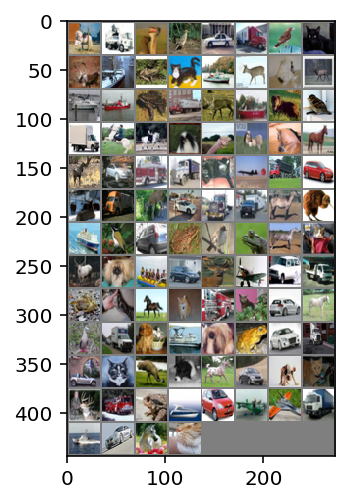

horse truck  bird  bird


In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [0]:
images.type()

'torch.FloatTensor'

In [0]:
def one_hot(ids):
    """
    ids: (list, ndarray) shape:[batch_size]
    out_tensor:FloatTensor shape:[batch_size, depth]
    """
    ids = ids.numpy()
    ids = torch.LongTensor(ids).view(-1, 1)
    #print(ids, (BATCH_SIZE, NUM_CLASSES))
#     out_tensor = torch.zeros(BATCH_SIZE, NUM_CLASSES).scatter_(1, ids, 1.)
    out_tensor = torch.zeros(len(ids), NUM_CLASSES).scatter_(1, ids, 1.)
    return out_tensor

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Naive supervised learning on CIFAR10 DATASET

In [0]:
def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        if n[0]:
            try:
                tensor = getattr(n[0], 'variable')
                print(n[0])
                print('Tensor with grad found:', tensor)
                print(' - gradient:', tensor.grad)
                print()
            except AttributeError as e:
                getBack(n[0])

In [0]:
criterion = CapsuleLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
def train(model, alpha, name, epochs, ensemble, trainloader, testloader):
  
    nets = [model().to(device) for i in range(ensemble)]
    optimizers = [optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4) for net in nets]
    
    val_acc = []
    train_acc = []
    train_loss = []
    

    for epoch in range(epochs):  # loop over the dataset multiple times

        print('\nEpoch: %d' % (epoch + 1))
        
        sum_loss = 0.0
        correct = 0.
        total = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
              
            length = len(trainloader)
            inputs, labels = data
            inputs = inputs.float()
            # print(inputs.shape)
            labels_one_hot = one_hot(labels)
            inputs, labels_one_hot, labels = inputs.to(device), labels_one_hot.to(device), labels.to(device)
            
            Outputs = torch.zeros([inputs.shape[0], NUM_CLASSES]).to(device)
            
            Reconstructions = torch.zeros(inputs.shape).to(device)
            
            loss = [torch.tensor(0) for i in range(ensemble)]
            
            for j in range(ensemble):
              
              
                nets[j].train()

                # zero the parameter gradients
                optimizers[j].zero_grad()
                # forward + backward + optimize
                outputs, reconstructions = nets[j](inputs)
                #print(outputs)
                loss[j] = criterion(inputs, labels_one_hot, outputs, reconstructions, alpha)
                # print(loss)
                loss[j].backward()
                # getBack(loss.grad_fn)
                optimizers[j].step()
                sum_loss += loss[j].item()
                Outputs += outputs
                Reconstructions += reconstructions
                
            
            Outputs /= float(ensemble)
            
           
                
            _, predicted = torch.max(Outputs.data, 1)
                
            total += labels.size(0)
            correct += predicted.eq(labels.data).sum()
            
            if i%20==19:
#                 for i in range(ensemble):
#                     print(loss[j].item())
                    
                # print(sum_loss / (i+1))
                print('[epoch:%d, iter:%d] Loss: %.3f | Acc: %.3f%% '
                    % (epoch + 1, (i + 1 + epoch * length), sum_loss / ensemble / (i + 1), 100. * correct / total))
            
        train_loss.append(sum_loss/length)
    
        train_acc.append(100. * correct / total)
    
        
        print("Waiting Test!")
        with torch.no_grad():
            correct = 0
            total = 0
            
            for data in testloader:
                
                images, labels = data
                images = images.float()
                images, labels = images.to(device), labels.to(device)
                Outputs = torch.zeros([images.shape[0], NUM_CLASSES]).to(device)
                
                for j in range(ensemble):
                    nets[j].eval()
                    outputs, reconstructions = nets[j](images)
                    Outputs += outputs
                
                Outputs /= ensemble
                _, predicted = torch.max(Outputs.data, 1)
                    
                
                total += labels.size(0)
                correct += (predicted == labels).sum()
            print('Accuracy：%.3f%%' % (100 * correct / total))
        
        val_acc.append(100 * correct / total)


    print(name+' finished Training')
    
    plt.figure()
    plt.plot([x for x in range(1,epochs+1)], val_acc, label='test accuracy')
    plt.plot([x for x in range(1,epochs+1)], train_acc, label='train accuracy')
    plt.xlabel('epoch number')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
  

## Baseline capsule model


Epoch: 1
[epoch:1, iter:20] Loss: 0.804 | Acc: 16.000% 
[epoch:1, iter:40] Loss: 0.794 | Acc: 20.000% 
[epoch:1, iter:60] Loss: 0.781 | Acc: 23.000% 
[epoch:1, iter:80] Loss: 0.773 | Acc: 25.000% 
[epoch:1, iter:100] Loss: 0.768 | Acc: 26.000% 
[epoch:1, iter:120] Loss: 0.761 | Acc: 27.000% 
[epoch:1, iter:140] Loss: 0.756 | Acc: 28.000% 
[epoch:1, iter:160] Loss: 0.753 | Acc: 29.000% 
[epoch:1, iter:180] Loss: 0.750 | Acc: 29.000% 
[epoch:1, iter:200] Loss: 0.745 | Acc: 30.000% 
[epoch:1, iter:220] Loss: 0.742 | Acc: 31.000% 
[epoch:1, iter:240] Loss: 0.738 | Acc: 31.000% 
[epoch:1, iter:260] Loss: 0.735 | Acc: 32.000% 
[epoch:1, iter:280] Loss: 0.732 | Acc: 32.000% 
[epoch:1, iter:300] Loss: 0.729 | Acc: 33.000% 
[epoch:1, iter:320] Loss: 0.726 | Acc: 33.000% 
[epoch:1, iter:340] Loss: 0.723 | Acc: 33.000% 
[epoch:1, iter:360] Loss: 0.720 | Acc: 34.000% 
[epoch:1, iter:380] Loss: 0.717 | Acc: 34.000% 
[epoch:1, iter:400] Loss: 0.714 | Acc: 35.000% 
[epoch:1, iter:420] Loss: 0.711 | 

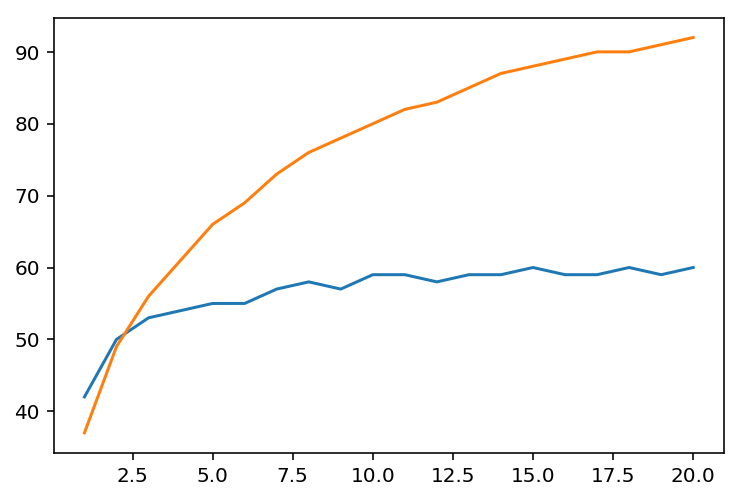

In [0]:
train(CapsuleNet_baseline, 0.0001, 'baseline', NUM_EPOCHS, 1)

## Baseline capsule model with 4 ensembles


Epoch: 1
[epoch:1, iter:20] Loss: 0.797 | Acc: 20.000% 
[epoch:1, iter:40] Loss: 0.783 | Acc: 25.000% 
[epoch:1, iter:60] Loss: 0.776 | Acc: 27.000% 
[epoch:1, iter:80] Loss: 0.769 | Acc: 29.000% 
[epoch:1, iter:100] Loss: 0.765 | Acc: 30.000% 
[epoch:1, iter:120] Loss: 0.761 | Acc: 31.000% 
[epoch:1, iter:140] Loss: 0.756 | Acc: 32.000% 
[epoch:1, iter:160] Loss: 0.752 | Acc: 33.000% 
[epoch:1, iter:180] Loss: 0.748 | Acc: 33.000% 
[epoch:1, iter:200] Loss: 0.744 | Acc: 34.000% 
[epoch:1, iter:220] Loss: 0.740 | Acc: 35.000% 
[epoch:1, iter:240] Loss: 0.737 | Acc: 35.000% 
[epoch:1, iter:260] Loss: 0.733 | Acc: 36.000% 
[epoch:1, iter:280] Loss: 0.729 | Acc: 36.000% 
[epoch:1, iter:300] Loss: 0.725 | Acc: 37.000% 
[epoch:1, iter:320] Loss: 0.722 | Acc: 37.000% 
[epoch:1, iter:340] Loss: 0.719 | Acc: 38.000% 
[epoch:1, iter:360] Loss: 0.717 | Acc: 38.000% 
[epoch:1, iter:380] Loss: 0.713 | Acc: 38.000% 
[epoch:1, iter:400] Loss: 0.711 | Acc: 39.000% 
[epoch:1, iter:420] Loss: 0.708 | 

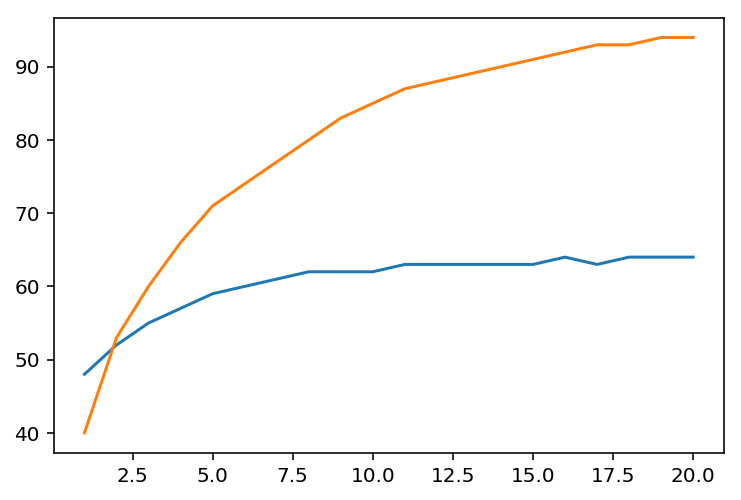

In [0]:
train(CapsuleNet_baseline, 0.0001, 'baseline', NUM_EPOCHS, 4)

## Deconv capsule model


Epoch: 1
[epoch:1, iter:20] Loss: 0.797 | Acc: 18.000% 
[epoch:1, iter:40] Loss: 0.784 | Acc: 21.000% 
[epoch:1, iter:60] Loss: 0.774 | Acc: 23.000% 
[epoch:1, iter:80] Loss: 0.766 | Acc: 25.000% 
[epoch:1, iter:100] Loss: 0.759 | Acc: 26.000% 
[epoch:1, iter:120] Loss: 0.752 | Acc: 27.000% 
[epoch:1, iter:140] Loss: 0.748 | Acc: 28.000% 
[epoch:1, iter:160] Loss: 0.743 | Acc: 29.000% 
[epoch:1, iter:180] Loss: 0.740 | Acc: 30.000% 
[epoch:1, iter:200] Loss: 0.737 | Acc: 30.000% 
[epoch:1, iter:220] Loss: 0.732 | Acc: 31.000% 
[epoch:1, iter:240] Loss: 0.728 | Acc: 31.000% 
[epoch:1, iter:260] Loss: 0.724 | Acc: 32.000% 
[epoch:1, iter:280] Loss: 0.721 | Acc: 32.000% 
[epoch:1, iter:300] Loss: 0.717 | Acc: 33.000% 
[epoch:1, iter:320] Loss: 0.714 | Acc: 33.000% 
[epoch:1, iter:340] Loss: 0.710 | Acc: 34.000% 
[epoch:1, iter:360] Loss: 0.706 | Acc: 34.000% 
[epoch:1, iter:380] Loss: 0.703 | Acc: 35.000% 
[epoch:1, iter:400] Loss: 0.700 | Acc: 35.000% 
[epoch:1, iter:420] Loss: 0.697 | 

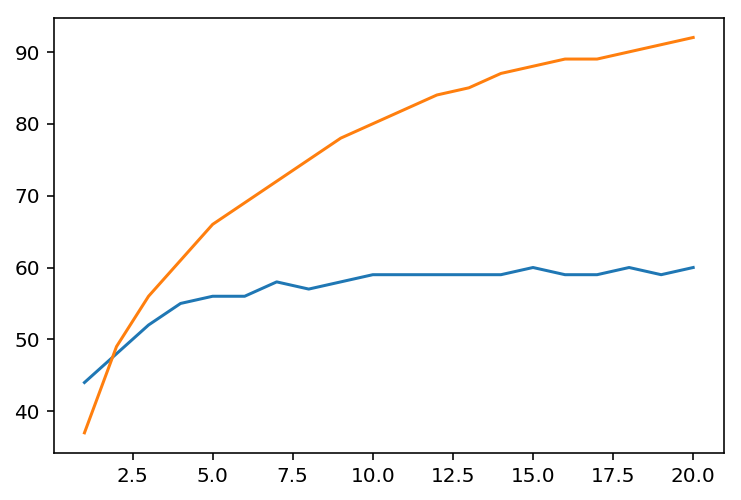

In [0]:
train(CapsuleNet_baseline_deconv, 0.0001, 'baseline_deconv', NUM_EPOCHS, 1)

## 3conv+deconv capsule model


Epoch: 1
[epoch:1, iter:20] Loss: 0.845 | Acc: 13.000% 
[epoch:1, iter:40] Loss: 0.826 | Acc: 15.000% 
[epoch:1, iter:60] Loss: 0.809 | Acc: 18.000% 
[epoch:1, iter:80] Loss: 0.797 | Acc: 20.000% 
[epoch:1, iter:100] Loss: 0.784 | Acc: 22.000% 
[epoch:1, iter:120] Loss: 0.776 | Acc: 24.000% 
[epoch:1, iter:140] Loss: 0.766 | Acc: 25.000% 
[epoch:1, iter:160] Loss: 0.759 | Acc: 26.000% 
[epoch:1, iter:180] Loss: 0.752 | Acc: 27.000% 
[epoch:1, iter:200] Loss: 0.746 | Acc: 28.000% 
[epoch:1, iter:220] Loss: 0.741 | Acc: 29.000% 
[epoch:1, iter:240] Loss: 0.733 | Acc: 30.000% 
[epoch:1, iter:260] Loss: 0.727 | Acc: 31.000% 
[epoch:1, iter:280] Loss: 0.722 | Acc: 31.000% 
[epoch:1, iter:300] Loss: 0.717 | Acc: 32.000% 
[epoch:1, iter:320] Loss: 0.712 | Acc: 33.000% 
[epoch:1, iter:340] Loss: 0.707 | Acc: 33.000% 
[epoch:1, iter:360] Loss: 0.703 | Acc: 34.000% 
[epoch:1, iter:380] Loss: 0.699 | Acc: 34.000% 
[epoch:1, iter:400] Loss: 0.695 | Acc: 35.000% 
[epoch:1, iter:420] Loss: 0.691 | 

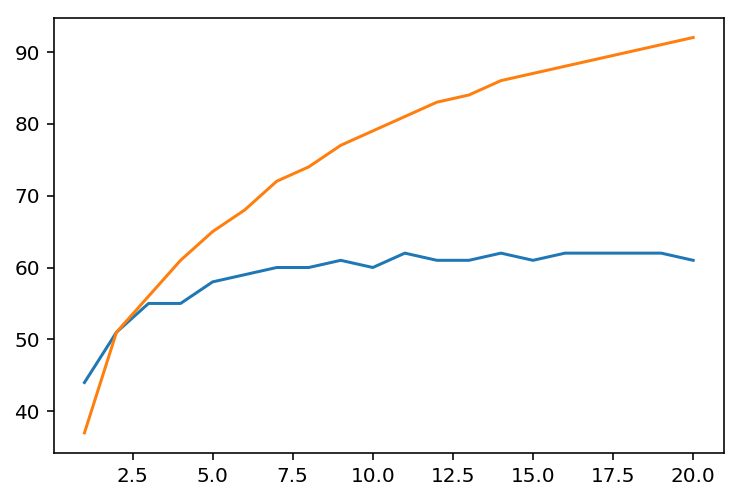

In [0]:
train(CapsuleNet_3conv_deconv, 0.0001, '3conv+deconv', NUM_EPOCHS, 1)

## 3conv+deconv capsule model with 4 ensembles


Epoch: 1
[epoch:1, iter:20] Loss: 0.823 | Acc: 15.000% 
[epoch:1, iter:40] Loss: 0.804 | Acc: 20.000% 
[epoch:1, iter:60] Loss: 0.790 | Acc: 22.000% 
[epoch:1, iter:80] Loss: 0.776 | Acc: 25.000% 
[epoch:1, iter:100] Loss: 0.769 | Acc: 26.000% 
[epoch:1, iter:120] Loss: 0.760 | Acc: 28.000% 
[epoch:1, iter:140] Loss: 0.751 | Acc: 29.000% 
[epoch:1, iter:160] Loss: 0.743 | Acc: 30.000% 
[epoch:1, iter:180] Loss: 0.737 | Acc: 31.000% 
[epoch:1, iter:200] Loss: 0.729 | Acc: 32.000% 
[epoch:1, iter:220] Loss: 0.722 | Acc: 33.000% 
[epoch:1, iter:240] Loss: 0.716 | Acc: 34.000% 
[epoch:1, iter:260] Loss: 0.711 | Acc: 35.000% 
[epoch:1, iter:280] Loss: 0.706 | Acc: 35.000% 
[epoch:1, iter:300] Loss: 0.701 | Acc: 36.000% 
[epoch:1, iter:320] Loss: 0.696 | Acc: 37.000% 
[epoch:1, iter:340] Loss: 0.691 | Acc: 37.000% 
[epoch:1, iter:360] Loss: 0.687 | Acc: 38.000% 
[epoch:1, iter:380] Loss: 0.683 | Acc: 38.000% 
[epoch:1, iter:400] Loss: 0.679 | Acc: 39.000% 
[epoch:1, iter:420] Loss: 0.675 | 

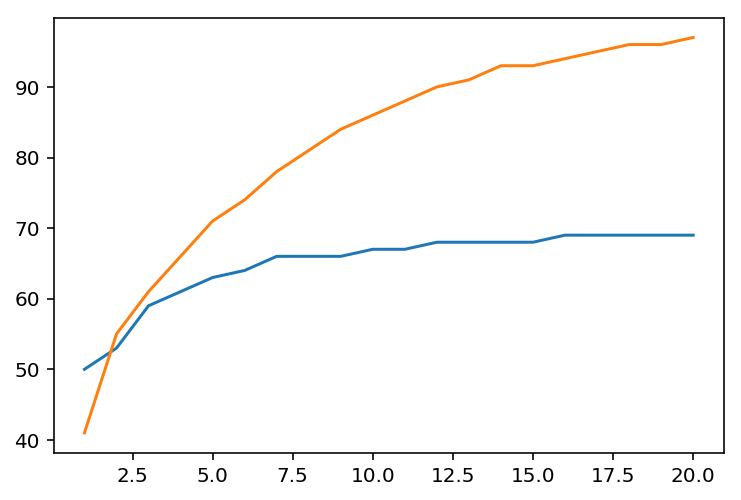

In [0]:
train(CapsuleNet_3conv_deconv, 0.0001, '3conv+deconv', NUM_EPOCHS, 4)

## 3conv+deconv capsule model with 7 ensembles


Epoch: 1
[epoch:1, iter:20] Loss: 0.814 | Acc: 16.000% 
[epoch:1, iter:40] Loss: 0.796 | Acc: 21.000% 
[epoch:1, iter:60] Loss: 0.783 | Acc: 24.000% 
[epoch:1, iter:80] Loss: 0.773 | Acc: 26.000% 
[epoch:1, iter:100] Loss: 0.763 | Acc: 27.000% 
[epoch:1, iter:120] Loss: 0.753 | Acc: 29.000% 
[epoch:1, iter:140] Loss: 0.744 | Acc: 30.000% 
[epoch:1, iter:160] Loss: 0.737 | Acc: 31.000% 
[epoch:1, iter:180] Loss: 0.730 | Acc: 32.000% 
[epoch:1, iter:200] Loss: 0.722 | Acc: 33.000% 
[epoch:1, iter:220] Loss: 0.716 | Acc: 34.000% 
[epoch:1, iter:240] Loss: 0.710 | Acc: 35.000% 
[epoch:1, iter:260] Loss: 0.705 | Acc: 36.000% 
[epoch:1, iter:280] Loss: 0.699 | Acc: 36.000% 
[epoch:1, iter:300] Loss: 0.695 | Acc: 37.000% 
[epoch:1, iter:320] Loss: 0.690 | Acc: 37.000% 
[epoch:1, iter:340] Loss: 0.685 | Acc: 38.000% 
[epoch:1, iter:360] Loss: 0.681 | Acc: 38.000% 
[epoch:1, iter:380] Loss: 0.678 | Acc: 39.000% 
[epoch:1, iter:400] Loss: 0.674 | Acc: 39.000% 
[epoch:1, iter:420] Loss: 0.670 | 

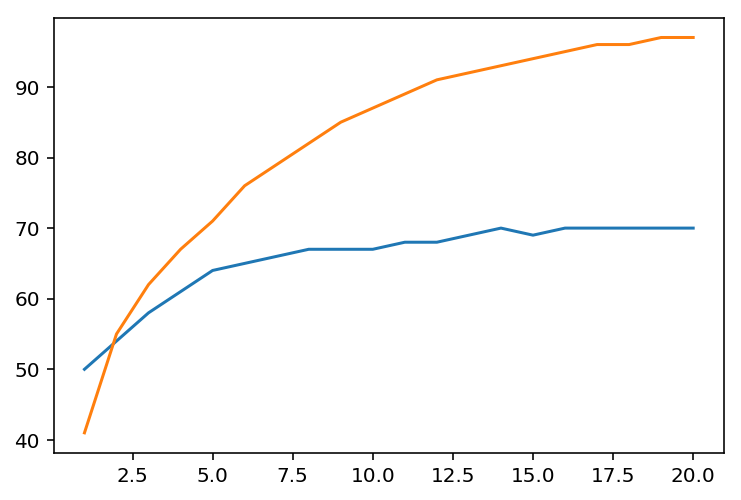

In [0]:
train(CapsuleNet_3conv_deconv, 0.0001, '3conv+deconv', NUM_EPOCHS, 7)

## 4conv+deconv capsule model


Epoch: 1
[epoch:1, iter:20] Loss: 0.804 | Acc: 12.000% 
[epoch:1, iter:40] Loss: 0.801 | Acc: 12.000% 
[epoch:1, iter:60] Loss: 0.794 | Acc: 15.000% 
[epoch:1, iter:80] Loss: 0.788 | Acc: 16.000% 
[epoch:1, iter:100] Loss: 0.780 | Acc: 18.000% 
[epoch:1, iter:120] Loss: 0.771 | Acc: 19.000% 
[epoch:1, iter:140] Loss: 0.766 | Acc: 21.000% 
[epoch:1, iter:160] Loss: 0.762 | Acc: 21.000% 
[epoch:1, iter:180] Loss: 0.758 | Acc: 22.000% 
[epoch:1, iter:200] Loss: 0.753 | Acc: 23.000% 
[epoch:1, iter:220] Loss: 0.748 | Acc: 24.000% 
[epoch:1, iter:240] Loss: 0.743 | Acc: 24.000% 
[epoch:1, iter:260] Loss: 0.739 | Acc: 25.000% 
[epoch:1, iter:280] Loss: 0.735 | Acc: 26.000% 
[epoch:1, iter:300] Loss: 0.730 | Acc: 26.000% 
[epoch:1, iter:320] Loss: 0.726 | Acc: 27.000% 
[epoch:1, iter:340] Loss: 0.722 | Acc: 27.000% 
[epoch:1, iter:360] Loss: 0.717 | Acc: 28.000% 
[epoch:1, iter:380] Loss: 0.713 | Acc: 28.000% 
[epoch:1, iter:400] Loss: 0.710 | Acc: 29.000% 
[epoch:1, iter:420] Loss: 0.706 | 

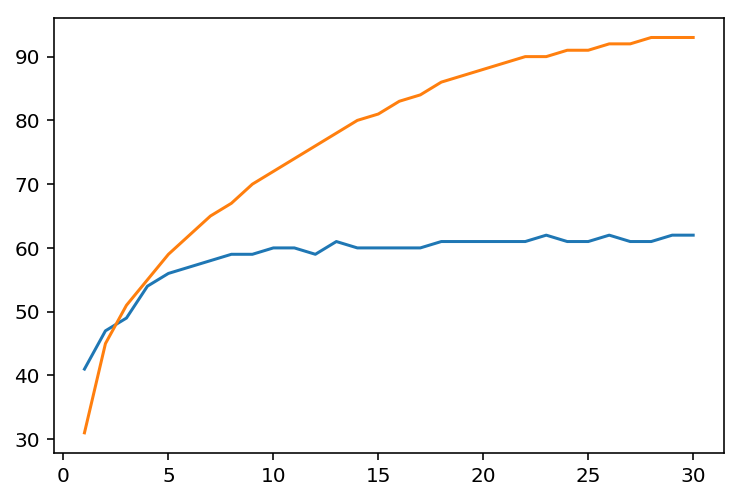

In [0]:
train(CapsuleNet_4conv_deconv, 0.0001, '4conv+deconv', 30, 1)

## 4conv+deconv capsule model with 4 ensembles


Epoch: 1
[epoch:1, iter:20] Loss: 0.807 | Acc: 13.000% 
[epoch:1, iter:40] Loss: 0.804 | Acc: 15.000% 
[epoch:1, iter:60] Loss: 0.799 | Acc: 17.000% 
[epoch:1, iter:80] Loss: 0.794 | Acc: 19.000% 
[epoch:1, iter:100] Loss: 0.786 | Acc: 21.000% 
[epoch:1, iter:120] Loss: 0.778 | Acc: 22.000% 
[epoch:1, iter:140] Loss: 0.772 | Acc: 23.000% 
[epoch:1, iter:160] Loss: 0.764 | Acc: 25.000% 
[epoch:1, iter:180] Loss: 0.758 | Acc: 26.000% 
[epoch:1, iter:200] Loss: 0.752 | Acc: 26.000% 
[epoch:1, iter:220] Loss: 0.747 | Acc: 27.000% 
[epoch:1, iter:240] Loss: 0.742 | Acc: 28.000% 
[epoch:1, iter:260] Loss: 0.736 | Acc: 29.000% 
[epoch:1, iter:280] Loss: 0.732 | Acc: 30.000% 
[epoch:1, iter:300] Loss: 0.727 | Acc: 30.000% 
[epoch:1, iter:320] Loss: 0.724 | Acc: 31.000% 
[epoch:1, iter:340] Loss: 0.720 | Acc: 31.000% 
[epoch:1, iter:360] Loss: 0.715 | Acc: 32.000% 
[epoch:1, iter:380] Loss: 0.712 | Acc: 32.000% 
[epoch:1, iter:400] Loss: 0.709 | Acc: 33.000% 
[epoch:1, iter:420] Loss: 0.705 | 

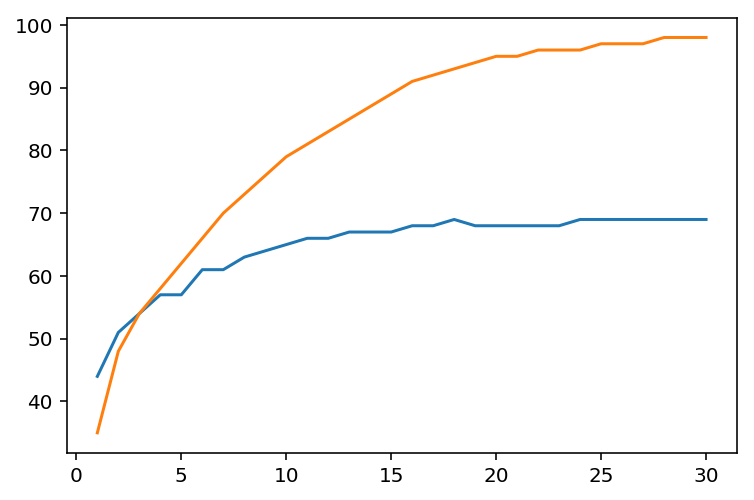

In [0]:
train(CapsuleNet_4conv_deconv, 0.0001, '4conv+deconv', 30, 4)

## 4conv+deconv capsule model with 7 ensembles


Epoch: 1
[epoch:1, iter:20] Loss: 0.811 | Acc: 12.000% 
[epoch:1, iter:40] Loss: 0.807 | Acc: 14.000% 
[epoch:1, iter:60] Loss: 0.802 | Acc: 17.000% 
[epoch:1, iter:80] Loss: 0.796 | Acc: 19.000% 
[epoch:1, iter:100] Loss: 0.788 | Acc: 21.000% 
[epoch:1, iter:120] Loss: 0.779 | Acc: 23.000% 
[epoch:1, iter:140] Loss: 0.773 | Acc: 24.000% 
[epoch:1, iter:160] Loss: 0.766 | Acc: 25.000% 
[epoch:1, iter:180] Loss: 0.760 | Acc: 26.000% 
[epoch:1, iter:200] Loss: 0.755 | Acc: 27.000% 
[epoch:1, iter:220] Loss: 0.748 | Acc: 28.000% 
[epoch:1, iter:240] Loss: 0.742 | Acc: 29.000% 
[epoch:1, iter:260] Loss: 0.738 | Acc: 30.000% 
[epoch:1, iter:280] Loss: 0.733 | Acc: 30.000% 
[epoch:1, iter:300] Loss: 0.729 | Acc: 31.000% 
[epoch:1, iter:320] Loss: 0.724 | Acc: 31.000% 
[epoch:1, iter:340] Loss: 0.720 | Acc: 32.000% 
[epoch:1, iter:360] Loss: 0.717 | Acc: 33.000% 
[epoch:1, iter:380] Loss: 0.713 | Acc: 33.000% 
[epoch:1, iter:400] Loss: 0.710 | Acc: 33.000% 
[epoch:1, iter:420] Loss: 0.707 | 

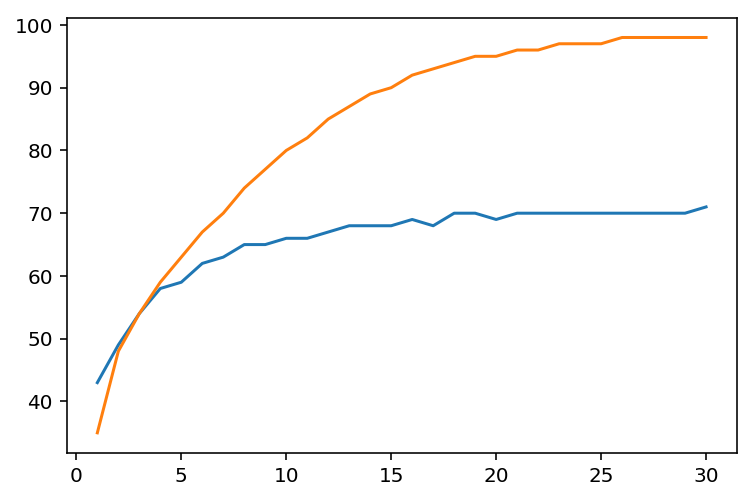

In [0]:
train(CapsuleNet_4conv_deconv, 0.0001, '4conv+deconv', 30, 7)

## Resnet+capsule model

In [0]:
net = CapsuleNet_resnet().to(device)
net(images.to(device))[0][0]

tensor([0.0652, 0.0856, 0.1433, 0.0526, 0.0390, 0.1419, 0.0840, 0.1453, 0.0837,
        0.1594], device='cuda:0', grad_fn=<SelectBackward>)


Epoch: 1
[epoch:1, iter:20] Loss: 0.806 | Acc: 14.000% 
[epoch:1, iter:40] Loss: 0.784 | Acc: 19.000% 
[epoch:1, iter:60] Loss: 0.763 | Acc: 24.000% 
[epoch:1, iter:80] Loss: 0.746 | Acc: 27.000% 
[epoch:1, iter:100] Loss: 0.731 | Acc: 29.000% 
[epoch:1, iter:120] Loss: 0.723 | Acc: 31.000% 
[epoch:1, iter:140] Loss: 0.714 | Acc: 32.000% 
[epoch:1, iter:160] Loss: 0.704 | Acc: 34.000% 
[epoch:1, iter:180] Loss: 0.695 | Acc: 35.000% 
[epoch:1, iter:200] Loss: 0.688 | Acc: 36.000% 
[epoch:1, iter:220] Loss: 0.684 | Acc: 37.000% 
[epoch:1, iter:240] Loss: 0.679 | Acc: 37.000% 
[epoch:1, iter:260] Loss: 0.674 | Acc: 38.000% 
[epoch:1, iter:280] Loss: 0.668 | Acc: 39.000% 
[epoch:1, iter:300] Loss: 0.664 | Acc: 39.000% 
[epoch:1, iter:320] Loss: 0.658 | Acc: 40.000% 
[epoch:1, iter:340] Loss: 0.654 | Acc: 41.000% 
[epoch:1, iter:360] Loss: 0.651 | Acc: 41.000% 
[epoch:1, iter:380] Loss: 0.648 | Acc: 41.000% 
[epoch:1, iter:400] Loss: 0.645 | Acc: 42.000% 
[epoch:1, iter:420] Loss: 0.641 | 

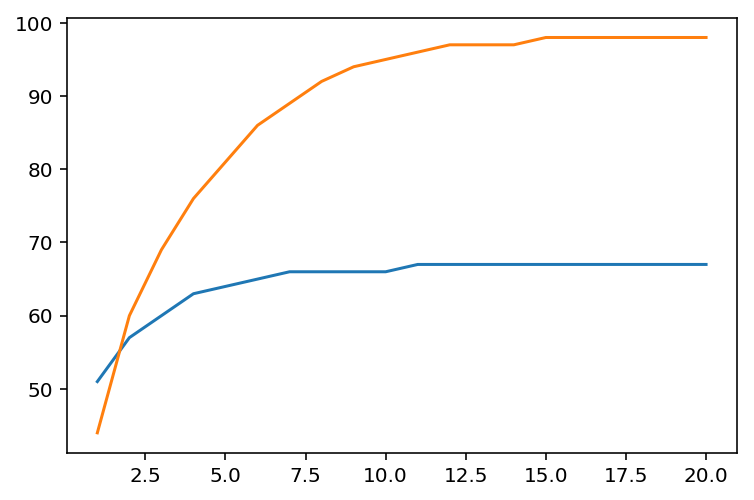

In [0]:
train(CapsuleNet_resnet, 0.0001, 'Capsule+resnet', 20, 1)

## Resnet+capsule model with 7 ensembles


Epoch: 1
[epoch:1, iter:20] Loss: 0.808 | Acc: 17.000% 
[epoch:1, iter:40] Loss: 0.782 | Acc: 25.000% 
[epoch:1, iter:60] Loss: 0.762 | Acc: 28.000% 
[epoch:1, iter:80] Loss: 0.746 | Acc: 31.000% 
[epoch:1, iter:100] Loss: 0.731 | Acc: 34.000% 
[epoch:1, iter:120] Loss: 0.717 | Acc: 36.000% 
[epoch:1, iter:140] Loss: 0.708 | Acc: 37.000% 
[epoch:1, iter:160] Loss: 0.699 | Acc: 39.000% 
[epoch:1, iter:180] Loss: 0.692 | Acc: 40.000% 
[epoch:1, iter:200] Loss: 0.684 | Acc: 41.000% 
[epoch:1, iter:220] Loss: 0.678 | Acc: 41.000% 
[epoch:1, iter:240] Loss: 0.674 | Acc: 42.000% 
[epoch:1, iter:260] Loss: 0.668 | Acc: 43.000% 
[epoch:1, iter:280] Loss: 0.663 | Acc: 43.000% 
[epoch:1, iter:300] Loss: 0.659 | Acc: 44.000% 
[epoch:1, iter:320] Loss: 0.654 | Acc: 45.000% 
[epoch:1, iter:340] Loss: 0.650 | Acc: 45.000% 
[epoch:1, iter:360] Loss: 0.647 | Acc: 45.000% 
[epoch:1, iter:380] Loss: 0.644 | Acc: 46.000% 
[epoch:1, iter:400] Loss: 0.640 | Acc: 46.000% 
[epoch:1, iter:420] Loss: 0.637 | 

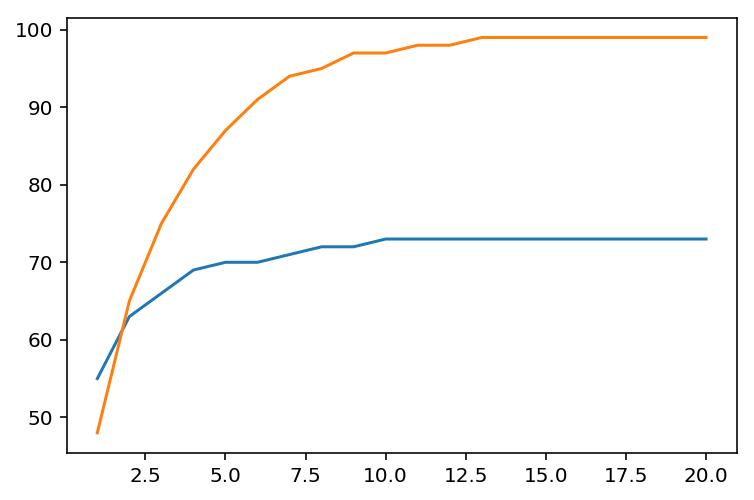

In [0]:
train(CapsuleNet_resnet, 0.0001, 'Capsule+resnet', 20, 7)

# data loader Yang

**import packages**

In [0]:
import cv2
# import os
import json
# import numpy as np
# from matplotlib import pyplot as plt

from torch.utils.data.dataset import Dataset
from random import shuffle
import torchvision.transforms as transforms
# # import torch
# import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
# from torch.autograd import Variable

**set paths**

In [0]:
root = '/content/gdrive/My Drive/cs280project/'
img_dir = root+'corrected_raw/'
train_dir = img_dir+'train/'
test_dir = img_dir+'test/'
json_path = root+'corrected_170.json'

**loader class and helpers**

In [0]:
def green_mask(img):
  frame = cv2.fastNlMeansDenoisingColored(img)
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#   lower_blue = np.array([20,30,50])
#   upper_blue = np.array([180,200,200])

  lower_blue = np.array([24,30,50])
  upper_blue = np.array([180,200,250])
  
  mask = cv2.inRange(hsv, lower_blue, upper_blue)
  res = cv2.bitwise_and(frame, frame, mask= mask)
  return res

**read JSON to dict{}**

In [0]:
def json2dict(json_path):
  # helper for read dataset
  label_dict = {}
  with open(json_path) as json_file:
    label_json = json.load(json_file)
    for label_info in label_json:
      label_file = label_info['Label']
      if label_file=='Skip': # nothing is labeled
        continue

      if 'crop' in label_file: # check if crop exist in this frame
        crop_list = []
        for loc in label_file['crop']:
          xy1 = loc['geometry'][0]
          xy2 = loc['geometry'][2]
          coord = np.array([[xy1['x'],xy1['y']],[xy2['x'],xy2['y']]])
          crop_list.append(coord)


      if 'weed' in label_file: # check if weed exist in this frame
        weed_list = []
        for loc in label_file['weed']:
          xy1 = loc['geometry'][0]
          xy2 = loc['geometry'][2]
          coord = np.array([[xy1['x'],xy1['y']],[xy2['x'],xy2['y']]])
          weed_list.append(coord)

        img_dict = {'crop':crop_list,'weed':weed_list}
        label_dict[label_info['External ID']] = img_dict
        
  return label_dict

**calculate the bounding box in original image**

In [0]:
def get_box(loc,h,w,rotate):
  # helper for read_dataset 在这里要处理好多rotate, 但是例如4377就是被乱转的。需要实验
  
  c = np.mean(loc,0)
  l = max(np.abs(loc[0]-loc[1]))

  # move center when box is out of bound
  c[0] = max(l/2,c[0])
  c[0] = min(h-l/2,c[0])
  c[1] = max(l/2,c[1]) if rotate else max(l/2,w-c[1])
  c[1] = min(w-l/2,c[1])

  # calc bound square
  x1 = int(c[0]-l/2)
  x2 = int(c[0]+l/2)
  y1 = int(c[1]-l/2)
  y2 = int(c[1]+l/2)
  
  if rotate:
    return y1,y2,x1,x2
  else:  
    return x1,x2,y1,y2

**load 2 classes of images for TrainingSetLoader**

In [0]:
def read_dataset(img_folder,json_path):
  # helper for TrainingSetLoader Class
  label_dict = json2dict(json_path)
  
  crop_samples = []
  weed_samples = []
  
  for filename in os.listdir(img_folder):
    if filename in label_dict: # that image is labeled
      
      print(filename)
      img = cv2.imread(img_folder+filename)
      h, w, _ = img.shape
      rotate = w>h # false means drive 上是竖着的，被labelbox转

      crop_locs = label_dict[filename]['crop']
      for loc in crop_locs:
        x1,x2,y1,y2 = get_box(loc,h,w,rotate)
        section = green_mask(img[x1:x2,y1:y2])
#         section = (img[x1:x2,y1:y2])
        section = 2*(section/255-0.5)
#         if filename in ['DSC04377.JPG','DSC04356.JPG','DSC04369.JPG','DSC04372.JPG']:
#           plt.imshow(section)
#           plt.show() 
        crop_samples.append(cv2.resize(section,(32,32))) #切出来，压到32

      weed_locs = label_dict[filename]['weed']
      for loc in weed_locs:
        x1,x2,y1,y2 = get_box(loc,h,w,rotate)
        section = green_mask(img[x1:x2,y1:y2])
#         section = (img[x1:x2,y1:y2])
        section = 2*(section/255-0.5)
#         if filename in ['DSC04377.JPG','DSC04356.JPG','DSC04369.JPG','DSC04372.JPG']:
#           plt.imshow(section)
#           plt.show()  
        weed_samples.append(cv2.resize(section,(32,32))) #切出来，压到32

  return crop_samples,weed_samples

In [0]:
class DataSetLoader(Dataset):
    def __init__(self, img_folder, json_path, transforms=None):
        """ Args:
            root (string): path to img file folder
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.img_folder = img_folder
        self.json_path = json_path
        self.images = self.retrieve_images()
        self.transforms = transforms

    def __getitem__(self, index):
        # get the images based on the index 
        item = self.images[index]
        # Return image matrix and the corresponding classification
        return item['mat'], item['val']

    def __len__(self):
        return len(self.images)

    # retrieve every image
    def retrieve_images(self):
        crop_samples,weed_samples = read_dataset(self.img_folder,self.json_path)
        crop_dict = [{'mat': np.rollaxis(x, 2, 0) , 'val': 0} for x in crop_samples]
        weed_dict = [{'mat': np.rollaxis(x, 2, 0) , 'val': 1} for x in weed_samples]
        mix_dict = crop_dict + weed_dict
        shuffle(mix_dict)
        return mix_dict

In [0]:
transformations = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(20,padding=4),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print('load train set')
train_data = DataSetLoader(train_dir, json_path, transformations)
trainloader1 = torch.utils.data.DataLoader(dataset=train_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True)
print('load test set')
test_data = DataSetLoader(test_dir, json_path)
testloader1 = torch.utils.data.DataLoader(dataset=test_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

load train set
DSC04356.JPG
DSC04357.JPG
DSC04359.JPG
DSC04360.JPG
DSC04361.JPG
DSC04362.JPG
DSC04363.JPG
DSC04365.JPG
DSC04366.JPG
DSC04368.JPG
DSC04369.JPG
DSC04370.JPG
DSC04371.JPG
DSC04372.JPG
DSC04373.JPG
DSC04375.JPG
DSC04376.JPG
DSC04377.JPG
DSC04378.JPG
DSC04379.JPG
DSC04380.JPG
DSC04381.JPG
DSC04382.JPG
DSC04383.JPG
DSC04385.JPG
DSC04386.JPG
DSC04387.JPG
DSC04388.JPG
DSC04389.JPG
DSC04390.JPG
DSC04391.JPG
DSC04392.JPG
DSC04393.JPG
DSC04395.JPG
DSC04396.JPG
DSC04397.JPG
DSC04398.JPG
DSC04399.JPG
DSC04400.JPG
DSC04401.JPG
DSC04402.JPG
DSC04404.JPG
DSC04405.JPG
DSC04406.JPG
DSC04407.JPG
DSC04408.JPG
DSC04409.JPG
DSC04410.JPG
DSC04411.JPG
DSC04412.JPG
DSC04414.JPG
DSC04415.JPG
DSC04416.JPG
DSC04417.JPG
DSC04418.JPG
DSC04419.JPG
DSC04420.JPG
DSC04422.JPG
DSC04423.JPG
DSC04424.JPG
DSC04425.JPG
DSC04426.JPG
DSC04427.JPG
DSC04428.JPG
DSC04429.JPG
DSC04430.JPG
DSC04431.JPG
DSC04432.JPG
DSC04434.JPG
DSC04435.JPG
DSC04436.JPG
DSC04437.JPG
DSC04438.JPG
DSC04439.JPG
DSC04441.JPG
DSC04442.J

In [0]:
classes = ('crop', 'weed')

torch.DoubleTensor


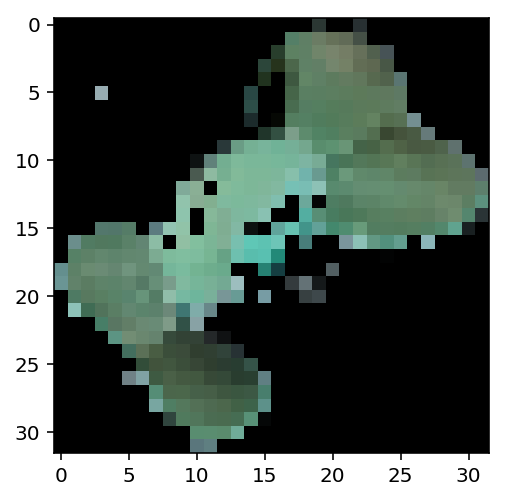

In [0]:
# get some random training images


dataiter = iter(testloader1)
images, labels = dataiter.next()
print(images.type())
# print(images[0])
imshow(images[2])
# images = (images.to(dtype=torch.float)/255-0.5)*2
# show images

# imshow(torchvision.utils.make_grid(images))
# print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [0]:
import time

# Train Weed with Yang's filter


Epoch: 1
[epoch:1, iter:20] Loss: 0.952 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 2
[epoch:2, iter:50] Loss: 0.964 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 3
[epoch:3, iter:80] Loss: 0.979 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 4
[epoch:4, iter:110] Loss: 0.965 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 5
[epoch:5, iter:140] Loss: 0.958 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 6
[epoch:6, iter:170] Loss: 0.948 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 7
[epoch:7, iter:200] Loss: 0.972 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 8
[epoch:8, iter:230] Loss: 0.959 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 9
[epoch:9, iter:260] Loss: 0.976 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 10
[epoch:10, iter:290] Loss: 0.972 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%
baseline finished Training


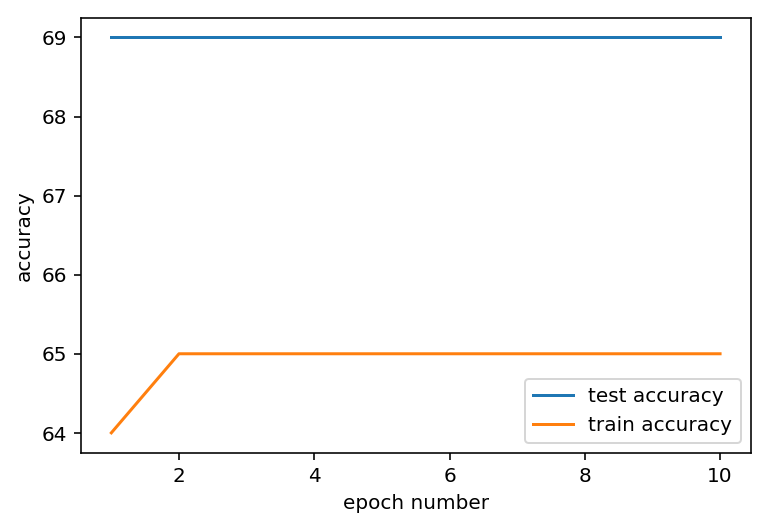

time cost:  41.1857430934906


In [0]:
t = time.time()
train(CapsuleNet_baseline, 0.0001, 'baseline', NUM_EPOCHS, 1, trainloader1, testloader1)
elapsed = time.time() - t
print('time cost: ',elapsed)


Epoch: 1
[epoch:1, iter:20] Loss: 0.971 | Acc: 63.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 2
[epoch:2, iter:50] Loss: 0.968 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 3
[epoch:3, iter:80] Loss: 0.974 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 4
[epoch:4, iter:110] Loss: 0.964 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 5
[epoch:5, iter:140] Loss: 0.954 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 6
[epoch:6, iter:170] Loss: 0.984 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 7
[epoch:7, iter:200] Loss: 0.973 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 8
[epoch:8, iter:230] Loss: 0.958 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 9
[epoch:9, iter:260] Loss: 0.962 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 10
[epoch:10, iter:290] Loss: 0.968 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%
baseline finished Training


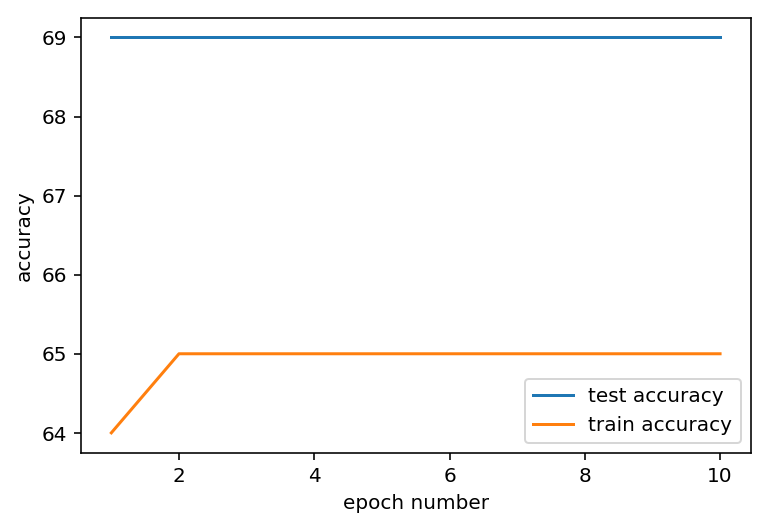

time cost:  166.9196674823761


In [0]:
t = time.time()
train(CapsuleNet_baseline, 0.0001, 'baseline', NUM_EPOCHS, 4, trainloader1, testloader1)
elapsed = time.time() - t
print('time cost: ',elapsed)


Epoch: 1
[epoch:1, iter:20] Loss: 0.983 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 2
[epoch:2, iter:50] Loss: 0.971 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 3
[epoch:3, iter:80] Loss: 0.958 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 4
[epoch:4, iter:110] Loss: 0.950 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 5
[epoch:5, iter:140] Loss: 0.963 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 6
[epoch:6, iter:170] Loss: 0.936 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 7
[epoch:7, iter:200] Loss: 0.934 | Acc: 66.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 8
[epoch:8, iter:230] Loss: 0.949 | Acc: 64.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 9
[epoch:9, iter:260] Loss: 0.928 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 10
[epoch:10, iter:290] Loss: 0.925 | Acc: 65.000% 
Waiting Test!
Accuracy：69.000%
3conv+deconv finished Training


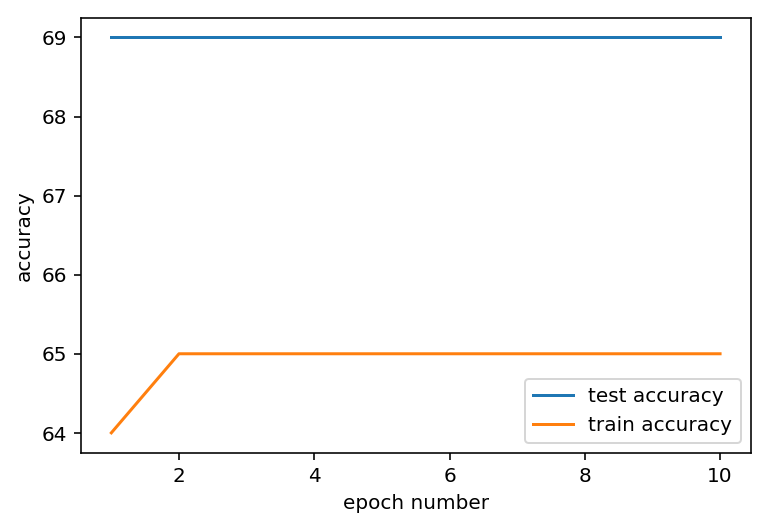

time cost:  114.85954976081848


In [0]:
t = time.time()
train(CapsuleNet_3conv_deconv, 0.0001, '3conv+deconv', NUM_EPOCHS, 4, trainloader1, testloader1)
elapsed = time.time() - t
print('time cost: ',elapsed)


Epoch: 1
[epoch:1, iter:20] Loss: 0.756 | Acc: 64.000% 
Waiting Test!
Accuracy：67.000%

Epoch: 2
[epoch:2, iter:50] Loss: 0.692 | Acc: 77.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 3
[epoch:3, iter:80] Loss: 0.663 | Acc: 80.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 4
[epoch:4, iter:110] Loss: 0.653 | Acc: 80.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 5
[epoch:5, iter:140] Loss: 0.636 | Acc: 81.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 6
[epoch:6, iter:170] Loss: 0.624 | Acc: 82.000% 
Waiting Test!
Accuracy：79.000%

Epoch: 7
[epoch:7, iter:200] Loss: 0.611 | Acc: 83.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 8
[epoch:8, iter:230] Loss: 0.601 | Acc: 84.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 9
[epoch:9, iter:260] Loss: 0.579 | Acc: 86.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 10
[epoch:10, iter:290] Loss: 0.573 | Acc: 85.000% 
Waiting Test!
Accuracy：78.000%
4conv+deconv finished Training


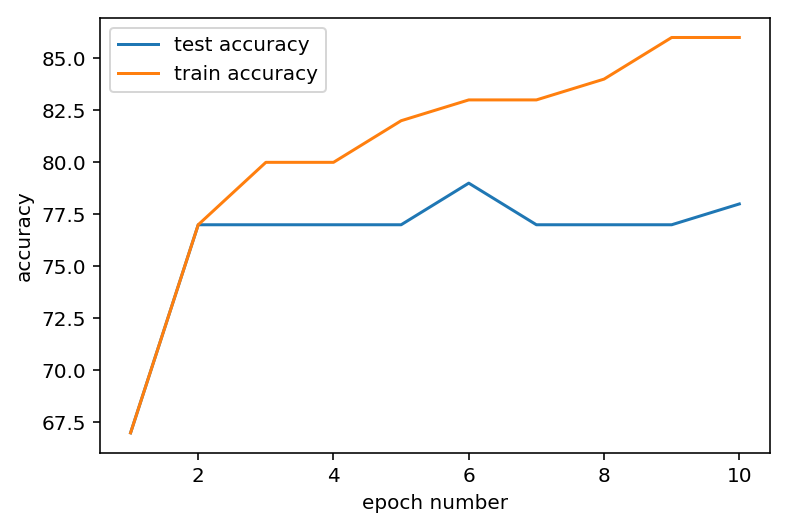

time cost:  105.26958751678467


In [0]:
t = time.time()
train(CapsuleNet_4conv_deconv, 0.0001, '4conv+deconv', NUM_EPOCHS, 4, trainloader1, testloader1)
elapsed = time.time() - t
print('time cost: ',elapsed)


Epoch: 1
[epoch:1, iter:20] Loss: 0.824 | Acc: 62.000% 
Waiting Test!
Accuracy：69.000%

Epoch: 2
[epoch:2, iter:50] Loss: 0.759 | Acc: 67.000% 
Waiting Test!
Accuracy：76.000%

Epoch: 3
[epoch:3, iter:80] Loss: 0.742 | Acc: 73.000% 
Waiting Test!
Accuracy：73.000%

Epoch: 4
[epoch:4, iter:110] Loss: 0.722 | Acc: 79.000% 
Waiting Test!
Accuracy：71.000%

Epoch: 5
[epoch:5, iter:140] Loss: 0.726 | Acc: 74.000% 
Waiting Test!
Accuracy：77.000%

Epoch: 6
[epoch:6, iter:170] Loss: 0.721 | Acc: 77.000% 
Waiting Test!
Accuracy：74.000%

Epoch: 7
[epoch:7, iter:200] Loss: 0.707 | Acc: 78.000% 
Waiting Test!
Accuracy：73.000%

Epoch: 8
[epoch:8, iter:230] Loss: 0.693 | Acc: 79.000% 
Waiting Test!
Accuracy：75.000%

Epoch: 9
[epoch:9, iter:260] Loss: 0.679 | Acc: 82.000% 
Waiting Test!
Accuracy：75.000%

Epoch: 10
[epoch:10, iter:290] Loss: 0.663 | Acc: 83.000% 
Waiting Test!
Accuracy：75.000%
4conv+deconv finished Training


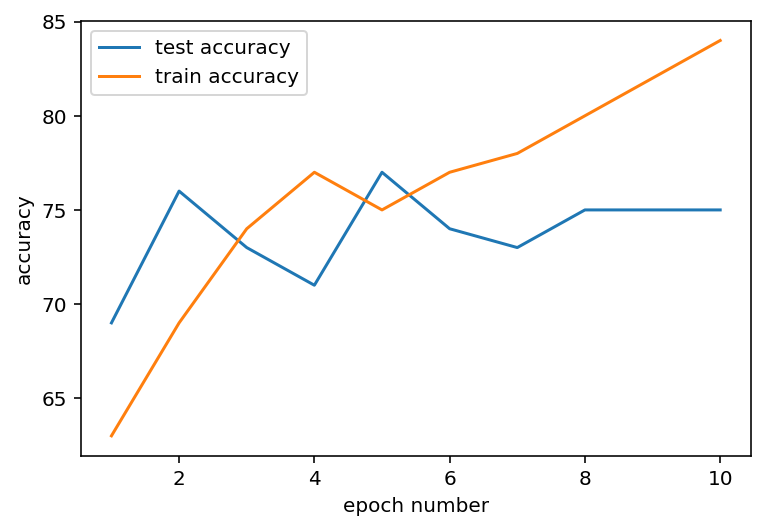

time cost:  188.03672575950623


In [0]:
t = time.time()
train(CapsuleNet_4conv_deconv, 0.0001, '4conv+deconv', NUM_EPOCHS, 7, trainloader1, testloader1)
elapsed = time.time() - t
print('time cost: ',elapsed)                       



Epoch: 1
[epoch:1, iter:20] Loss: 0.726 | Acc: 76.000% 
Waiting Test!
Accuracy：73.000%

Epoch: 2
[epoch:2, iter:50] Loss: 0.630 | Acc: 89.000% 
Waiting Test!
Accuracy：81.000%

Epoch: 3
[epoch:3, iter:80] Loss: 0.596 | Acc: 93.000% 
Waiting Test!
Accuracy：81.000%

Epoch: 4
[epoch:4, iter:110] Loss: 0.580 | Acc: 94.000% 
Waiting Test!
Accuracy：81.000%

Epoch: 5
[epoch:5, iter:140] Loss: 0.566 | Acc: 94.000% 
Waiting Test!
Accuracy：83.000%

Epoch: 6
[epoch:6, iter:170] Loss: 0.554 | Acc: 95.000% 
Waiting Test!
Accuracy：82.000%

Epoch: 7
[epoch:7, iter:200] Loss: 0.542 | Acc: 96.000% 
Waiting Test!
Accuracy：81.000%

Epoch: 8
[epoch:8, iter:230] Loss: 0.539 | Acc: 95.000% 
Waiting Test!
Accuracy：81.000%

Epoch: 9
[epoch:9, iter:260] Loss: 0.530 | Acc: 95.000% 
Waiting Test!
Accuracy：81.000%

Epoch: 10
[epoch:10, iter:290] Loss: 0.519 | Acc: 96.000% 
Waiting Test!
Accuracy：82.000%
Capsule+resnet finished Training


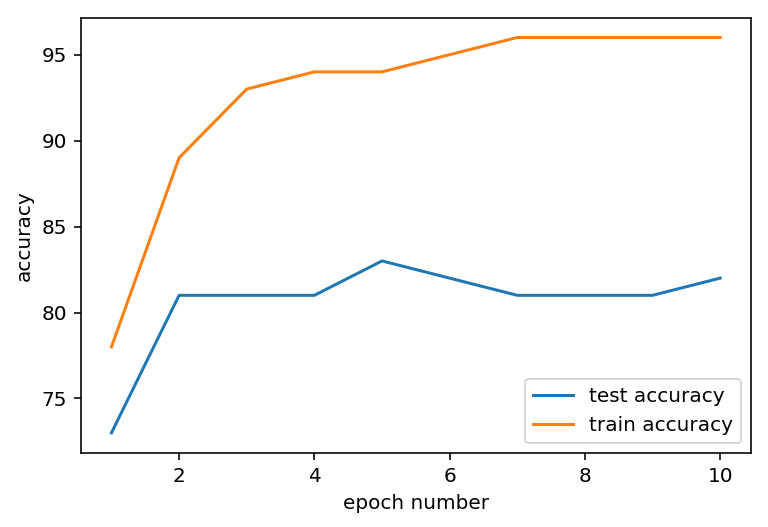

time cost:  325.7499129772186


In [0]:
t = time.time()
train(CapsuleNet_resnet, 0.0001, 'Capsule+resnet', NUM_EPOCHS, 7, trainloader1, testloader1)
elapsed = time.time() - t
print('time cost: ',elapsed)      


# RESNET

In [0]:
# import torch.nn as nn
# import torch.utils.model_zoo as model_zoo


# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#            'resnet152']


# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
# }


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet7(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [1, 1, 1, 0], **kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url(model_urls['resnet7']))
    return model
      
      
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [0]:
len(classes)

2

RES18

cuda
[epoch:11, iter:320] Loss: 0.595 | Acc: 69.000% 
Waiting Test!
Accuracy：73.000%
[epoch:11, iter:320] Loss: 0.469 | Acc: 77.000% 
Waiting Test!
Accuracy：78.000%
[epoch:11, iter:320] Loss: 0.450 | Acc: 79.000% 
Waiting Test!
Accuracy：79.000%
[epoch:11, iter:320] Loss: 0.413 | Acc: 80.000% 
Waiting Test!
Accuracy：79.000%
[epoch:11, iter:320] Loss: 0.344 | Acc: 83.000% 
Waiting Test!
Accuracy：76.000%
[epoch:11, iter:320] Loss: 0.326 | Acc: 85.000% 
Waiting Test!
Accuracy：78.000%
[epoch:11, iter:320] Loss: 0.279 | Acc: 86.000% 
Waiting Test!
Accuracy：80.000%
[epoch:11, iter:320] Loss: 0.250 | Acc: 88.000% 
Waiting Test!
Accuracy：85.000%
[epoch:11, iter:320] Loss: 0.224 | Acc: 89.000% 
Waiting Test!
Accuracy：84.000%
[epoch:11, iter:320] Loss: 0.201 | Acc: 90.000% 
Waiting Test!
Accuracy：85.000%
res18 finished Training


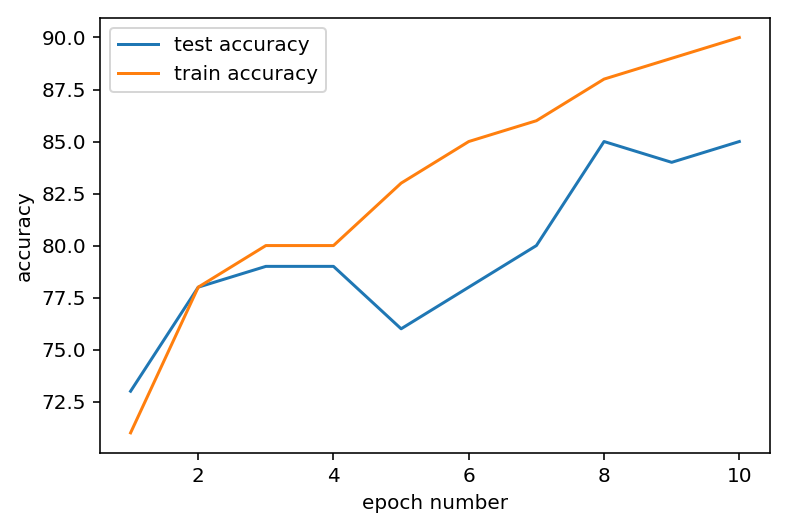

time cost:  12.020268440246582


In [0]:
t = time.time()
train_loss = []
train_acc = []
val_acc = []
# train(resnet18, 0.0001, 'res18', NUM_EPOCHS, 1, trainloader1, testloader1)
net = resnet18(num_classes=len(classes)).to(device)

print(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=1e-4)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

net.train()

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    correct = 0.
    total = 0.0
    sum_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        # get the inputs
        length = len(trainloader1)
        inputs, labels = data
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        sum_loss += loss.item()

            
           
                
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += predicted.eq(labels.data).sum()

        if i%20==19:
#                 for i in range(ensemble):
#                     print(loss[j].item())

            # print(sum_loss / (i+1))
          print('[epoch:%d, iter:%d] Loss: %.3f | Acc: %.3f%% '
              % (NUM_EPOCHS + 1, (i + 1 + NUM_EPOCHS * length), sum_loss / (i + 1), 100. * correct / total))

    train_loss.append(sum_loss/length)

    train_acc.append(100. * correct / total)


    print("Waiting Test!")
    with torch.no_grad():
        correct = 0
        total = 0

        for data in testloader1:

            images, labels = data
            images = images.float()
            images, labels = images.to(device), labels.to(device)
            Outputs = torch.zeros([images.shape[0], NUM_CLASSES]).to(device)

            net.eval()
            outputs = net(images)
            Outputs += outputs

            _, predicted = torch.max(Outputs.data, 1)


            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Accuracy：%.3f%%' % (100 * correct / total))

    val_acc.append(100 * correct / total)


print('res18 finished Training')

plt.figure()
plt.plot([x for x in range(1,NUM_EPOCHS+1)], val_acc, label='test accuracy')
plt.plot([x for x in range(1,NUM_EPOCHS+1)], train_acc, label='train accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.legend()
plt.show()



elapsed = time.time() - t
print('time cost: ',elapsed)

RES7

cuda
[epoch:11, iter:320] Loss: 0.630 | Acc: 64.000% 
Waiting Test!
Accuracy：72.000%
[epoch:11, iter:320] Loss: 0.468 | Acc: 77.000% 
Waiting Test!
Accuracy：77.000%
[epoch:11, iter:320] Loss: 0.396 | Acc: 81.000% 
Waiting Test!
Accuracy：79.000%
[epoch:11, iter:320] Loss: 0.346 | Acc: 84.000% 
Waiting Test!
Accuracy：77.000%
[epoch:11, iter:320] Loss: 0.314 | Acc: 84.000% 
Waiting Test!
Accuracy：79.000%
[epoch:11, iter:320] Loss: 0.293 | Acc: 86.000% 
Waiting Test!
Accuracy：79.000%
[epoch:11, iter:320] Loss: 0.255 | Acc: 88.000% 
Waiting Test!
Accuracy：80.000%
[epoch:11, iter:320] Loss: 0.231 | Acc: 90.000% 
Waiting Test!
Accuracy：77.000%
[epoch:11, iter:320] Loss: 0.225 | Acc: 89.000% 
Waiting Test!
Accuracy：84.000%
[epoch:11, iter:320] Loss: 0.166 | Acc: 92.000% 
Waiting Test!
Accuracy：84.000%
res18 finished Training


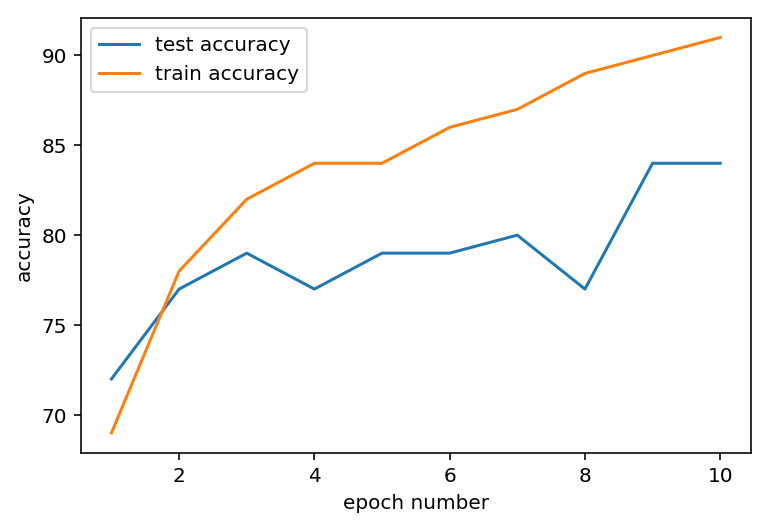

time cost:  8.302051782608032


In [0]:
t = time.time()
train_loss = []
train_acc = []
val_acc = []
# train(resnet18, 0.0001, 'res18', NUM_EPOCHS, 1, trainloader1, testloader1)
net = resnet7(num_classes=len(classes)).to(device)

print(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=1e-4)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

net.train()

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    correct = 0.
    total = 0.0
    sum_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        # get the inputs
        length = len(trainloader1)
        inputs, labels = data
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        sum_loss += loss.item()

            
           
                
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += predicted.eq(labels.data).sum()

        if i%20==19:
#                 for i in range(ensemble):
#                     print(loss[j].item())

            # print(sum_loss / (i+1))
          print('[epoch:%d, iter:%d] Loss: %.3f | Acc: %.3f%% '
              % (NUM_EPOCHS + 1, (i + 1 + NUM_EPOCHS * length), sum_loss / (i + 1), 100. * correct / total))

    train_loss.append(sum_loss/length)

    train_acc.append(100. * correct / total)


    print("Waiting Test!")
    with torch.no_grad():
        correct = 0
        total = 0

        for data in testloader1:

            images, labels = data
            images = images.float()
            images, labels = images.to(device), labels.to(device)
            Outputs = torch.zeros([images.shape[0], NUM_CLASSES]).to(device)

            net.eval()
            outputs = net(images)
            Outputs += outputs

            _, predicted = torch.max(Outputs.data, 1)


            total += labels.size(0)
            correct += (predicted == labels).sum()
        print('Accuracy：%.3f%%' % (100 * correct / total))

    val_acc.append(100 * correct / total)


print('res18 finished Training')

plt.figure()
plt.plot([x for x in range(1,NUM_EPOCHS+1)], val_acc, label='test accuracy')
plt.plot([x for x in range(1,NUM_EPOCHS+1)], train_acc, label='train accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy')
plt.legend()
plt.show()



elapsed = time.time() - t
print('time cost: ',elapsed)